In [1]:
%load_ext autoreload
%autoreload 2

import scipy
import numpy as np
import matplotlib.pyplot as plt
import keras
# use torch backend
import torch

import time



2024-08-23 12:11:25.322843: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-23 12:11:25.375326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 12:11:25.375363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 12:11:25.376382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 12:11:25.382511: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Distribution Settings
scale = 1
mean = 0

normal_dist = scipy.stats.norm(loc=mean, scale=scale)

# Number of independent datapoints 
T = 1000

seed=360
rng = np.random.RandomState(seed)
y_T = torch.Tensor(normal_dist.rvs(size=T, random_state=rng))
y_T.requires_grad_(True)
# supress cell output
''''''

''

In [17]:
M = 2

start = time.time()

vals, losses, anal_grad_theta, numer_grad_theta, anal_grad_L, numer_grad_L, anal_grad, numer_grad = [], [], [], [], [], [], [], []

for param_value in np.linspace(-5, 5, 11, dtype=np.float32):

    param = torch.tensor([param_value], requires_grad=True)
    print(param_value)

    for trial in range(10):
        print(trial)

        # Get some samples from the implied distribution
        param_sized = param*torch.ones(T)
        distribution = torch.distributions.Normal(loc=param_sized, scale=1)
        samples_MT = distribution.sample(sample_shape=(M,))

        # calculate the log prob of those samples
        # log probs cannot be an argument, must be "baked" into function
        def get_log_probs_baked(param):
            param_sized = param*torch.ones(T)
            distribution = torch.distributions.Normal(loc=param_sized, scale=1)
            log_probs_MT = distribution.log_prob(samples_MT)

            return log_probs_MT
        
        analytical_grad_theta_wrt_phi_MT = (samples_MT -param)*samples_MT
        jac_log_prob_MT = torch.autograd.functional.jacobian(get_log_probs_baked, (param), strategy='forward-mode', vectorize=True)
        autodiff_grad_theta_wrt_phi_MT = jac_log_prob_MT * torch.unsqueeze(samples_MT, dim=-1)
        analytical_grad_theta_wrt_phi_T = torch.mean(analytical_grad_theta_wrt_phi_MT, dim=0)
        autodiff_grad_theta_wrt_phi_T = torch.mean(autodiff_grad_theta_wrt_phi_MT, dim=0)

        action_samples_MT = distribution.sample(sample_shape=(M,))
        expected_action_T = torch.mean(action_samples_MT, dim=0)
        expected_action_T.requires_grad_(True)
        # ge
        loss_T = torch.nn.functional.mse_loss(expected_action_T, y_T)
        analytical_grad_L_wrt_theta_T = -2.0*(y_T - expected_action_T)
        loss_T.backward()
        autodiff_grad_L_wrt_theta_T = expected_action_T.grad

        analytical_grad_T = analytical_grad_theta_wrt_phi_T * torch.unsqueeze(analytical_grad_L_wrt_theta_T, 1)
        autodiff_grad_T = autodiff_grad_theta_wrt_phi_T * torch.unsqueeze(autodiff_grad_L_wrt_theta_T, 1)

        vals.append(param_value)
        losses.append(loss_T.detach().numpy())
        anal_grad_theta.append(analytical_grad_theta_wrt_phi_T.detach().numpy())
        numer_grad_theta.append(autodiff_grad_theta_wrt_phi_T.detach().numpy())
        anal_grad_L.append(analytical_grad_L_wrt_theta_T.detach().numpy())
        numer_grad_L.append(autodiff_grad_L_wrt_theta_T.detach().numpy())
        anal_grad.append(analytical_grad_T.detach().numpy())
        numer_grad.append(autodiff_grad_T.detach().numpy())

end = time.time()
elapsed = end - start

-5.0
0
1
2
3
4
5
6
7
8
9
-4.0
0
1
2
3
4
5
6
7
8
9
-3.0
0
1
2
3
4
5
6
7
8
9
-2.0
0
1
2
3
4
5
6
7
8
9
-1.0
0
1
2
3
4
5
6
7
8
9
0.0
0
1
2
3
4
5
6
7
8
9
1.0
0
1
2
3
4
5
6
7
8
9
2.0
0
1
2
3
4
5
6
7
8
9
3.0
0
1
2
3
4
5
6
7
8
9
4.0
0
1
2
3
4
5
6
7
8
9
5.0
0
1
2
3
4
5
6
7
8
9


In [12]:
samples_MT.shape

torch.Size([2, 1000])

In [13]:
autodiff_grad_L_wrt_theta_T

tensor([0.0081, 0.0108, 0.0117, 0.0154, 0.0126, 0.0078, 0.0122, 0.0100, 0.0102,
        0.0089, 0.0083, 0.0127, 0.0110, 0.0123, 0.0151, 0.0086, 0.0116, 0.0060,
        0.0117, 0.0093, 0.0043, 0.0119, 0.0126, 0.0075, 0.0089, 0.0093, 0.0092,
        0.0141, 0.0102, 0.0116, 0.0082, 0.0101, 0.0062, 0.0086, 0.0101, 0.0102,
        0.0108, 0.0049, 0.0140, 0.0079, 0.0105, 0.0103, 0.0181, 0.0086, 0.0108,
        0.0053, 0.0066, 0.0100, 0.0123, 0.0088, 0.0101, 0.0105, 0.0097, 0.0077,
        0.0089, 0.0075, 0.0111, 0.0091, 0.0100, 0.0115, 0.0122, 0.0089, 0.0107,
        0.0141, 0.0071, 0.0113, 0.0110, 0.0115, 0.0129, 0.0123, 0.0101, 0.0080,
        0.0078, 0.0094, 0.0082, 0.0142, 0.0089, 0.0075, 0.0079, 0.0097, 0.0077,
        0.0112, 0.0109, 0.0059, 0.0103, 0.0109, 0.0086, 0.0054, 0.0108, 0.0079,
        0.0084, 0.0122, 0.0109, 0.0113, 0.0104, 0.0134, 0.0095, 0.0112, 0.0158,
        0.0108, 0.0088, 0.0117, 0.0079, 0.0074, 0.0105, 0.0112, 0.0093, 0.0148,
        0.0116, 0.0086, 0.0112, 0.0082, 

Text(0.5, 1.0, '$\\nabla_\\phi \\mathcal{L}$, M=2,time: 0.28s')

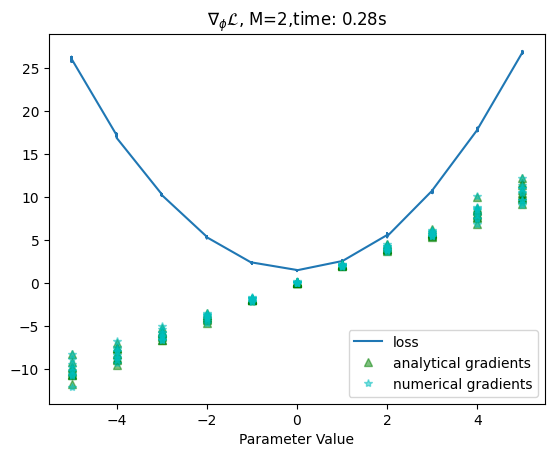

In [18]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad], 'g^',alpha=0.5, label='analytical gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad], 'c*',alpha=0.5, label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')

Text(0.5, 1.0, '$\\nabla_\\phi \\mathcal{\\theta}$, M=2,time: 0.25s')

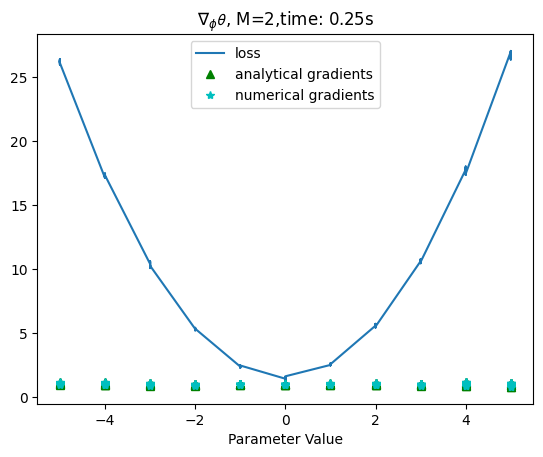

In [15]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_theta], 'g^', label='analytical gradients')
ax1.plot(vals, [np.mean(grad) for grad in numer_grad_theta], 'c*', label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{\theta}$, '+f'M={M},time: {elapsed:.2f}s')

Text(0.5, 1.0, '$\\nabla_\\theta \\mathcal{L}$, M=2,time: 0.25s')

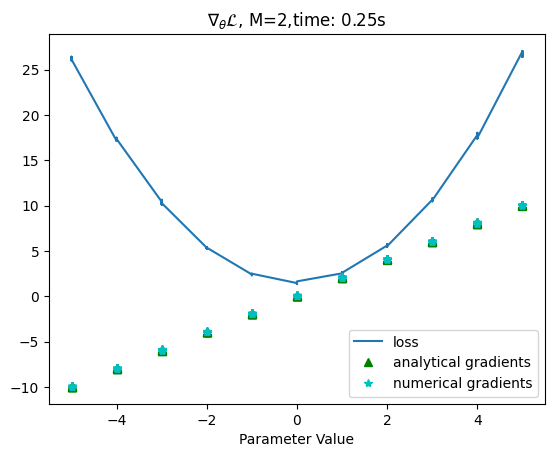

In [16]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_L], 'g^', label='analytical gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad_L], 'c*', label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\theta \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')

Text(0.5, 1.0, '$\\nabla_\\theta \\mathcal{L}$, M=10000,time: 55.68s')

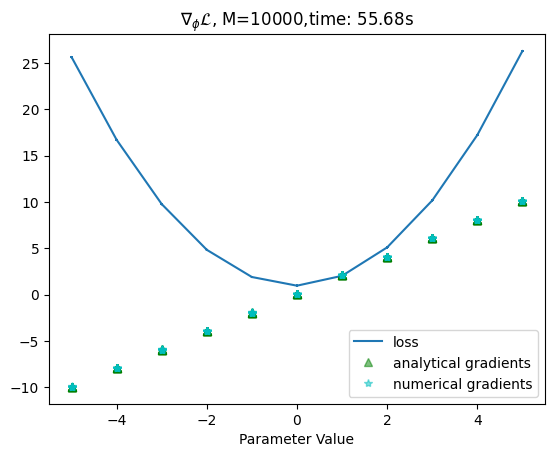

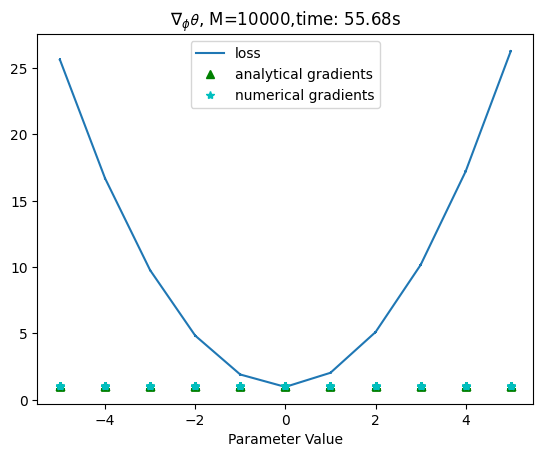

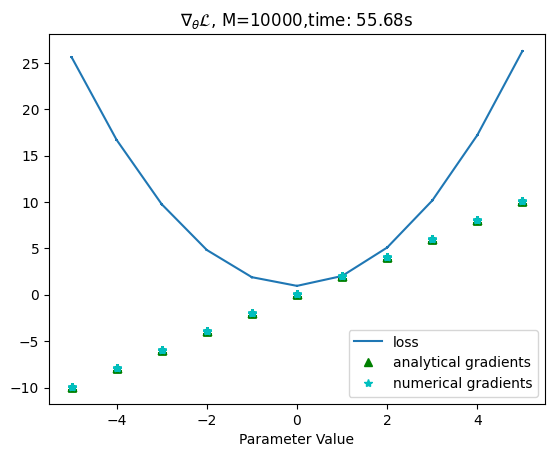

In [128]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad], 'g^',alpha=0.5, label='analytical gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad], 'c*',alpha=0.5, label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')

fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_theta], 'g^', label='analytical gradients')
ax1.plot(vals, [np.mean(grad) for grad in numer_grad_theta], 'c*', label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{\theta}$, '+f'M={M},time: {elapsed:.2f}s')

fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_L], 'g^', label='analytical gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad_L], 'c*', label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\theta \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')


In [50]:
[np.mean(grad) for grad in numer_grad]

[0.00018617946,
 -0.00027258732,
 -5.2011237e-06,
 0.00018365102,
 0.000123873,
 0.00013241598,
 -2.3332432e-05,
 0.000257431,
 0.0005547508,
 2.5422756e-05,
 5.502917e-05,
 4.058681e-05,
 -8.9222354e-05,
 4.7139165e-05,
 -8.102873e-05,
 -0.00038875663,
 0.00058035814,
 -0.000119333075,
 0.0001392584,
 8.97855e-05,
 4.1955376e-05,
 -0.00018266427,
 -4.806988e-05,
 2.6495443e-05,
 -7.832831e-05,
 -0.0001801407,
 -3.772761e-05,
 -5.5536686e-05,
 8.851932e-05,
 3.5748806e-05,
 -0.00016392716,
 4.1696196e-05,
 5.5270284e-05,
 6.95133e-05,
 -0.0001422174,
 3.8993287e-05,
 2.7167164e-06,
 9.310095e-05,
 -1.5208155e-05,
 -1.797727e-05,
 -0.00013850893,
 -9.623717e-05,
 -3.123299e-05,
 5.0106577e-05,
 -4.6711626e-05,
 4.157176e-05,
 -3.8398033e-05,
 0.00018139397,
 -1.8739813e-05,
 -9.026251e-05,
 -3.056829e-05,
 -1.7068262e-05,
 -1.4013566e-05,
 3.957633e-05,
 8.110906e-05,
 -7.5455087e-06,
 -2.4022564e-05,
 -4.279674e-05,
 -4.1547206e-05,
 3.330332e-05,
 2.0290267e-05,
 8.44038e-05,
 -5.5854

In [51]:
[np.mean(grad) for grad in numer_grad_theta]

[-0.019893425,
 0.024868539,
 0.00409787,
 -0.017555978,
 -0.011278702,
 -0.0072144833,
 0.005025932,
 -0.018429825,
 -0.058510024,
 0.009745349,
 -0.0074980143,
 -0.013480158,
 0.0074054548,
 0.0022459335,
 0.004421507,
 0.046300508,
 -0.06101053,
 0.014492712,
 -0.009784353,
 -0.014391062,
 -0.0030888782,
 0.028707817,
 0.0029996757,
 -0.003252427,
 0.011040169,
 0.026075587,
 0.011770829,
 0.006976722,
 -0.016736457,
 0.0043304074,
 0.023487004,
 -0.01060179,
 -0.019311331,
 -0.025998836,
 0.035514113,
 0.0009665928,
 0.007890291,
 -0.030522019,
 -0.0038923903,
 -0.008654033,
 0.016917644,
 2.8090477e-05,
 0.024836106,
 -0.0510255,
 0.0026977253,
 -0.022508984,
 0.024374837,
 -0.070717394,
 0.003299064,
 -0.007853807,
 -0.017073784,
 -0.0369885,
 -0.01758736,
 -0.0206553,
 -0.024274934,
 -0.01278419,
 -0.032421265,
 -0.043887947,
 -0.007343233,
 -0.021382317,
 0.014731523,
 0.03125373,
 -0.023854226,
 -0.019992119,
 0.0017599848,
 0.017516369,
 0.0069587673,
 -0.008510141,
 -0.00588